# Using Data From BigQuery to Build a Model in TensorFlow

Create BigQuery client and then send a query to the client to execute

In [1]:
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

Query the all_seasons table in the baseball_all_seasons dataset in the machinelearning-339423 project

In [4]:
### Run a query on BigQuery data
query = """
    select
        Name,
        avg(WAR) as avg_war,
        sum(WAR) / sum(PA) as war_per_pa
    from 
         `machinelearning-339423.baseball_all_seasons.all_seasons`
    group by Name
    having sum(PA) > 2500
    order by war_per_pa desc
    limit 50
"""
job = client.query(query)
df = job.to_dataframe()

In [5]:
df.head()

,Name,avg_war,war_per_pa
0,Babe Ruth,7.663636,0.015882
1,Mike Trout,8.125000,0.013910
2,Rogers Hornsby,5.660870,0.013741
3,Ted Williams,6.868421,0.013329
4,Barry Bonds,7.477273,0.013049


Now let's run a query to get all offensive counting stats for each player each season to predict Offensive WAR 

In [6]:
### Get offensive counting stats per player and season
query = """
select
  playerid,
  Name,
  Season,
  sum(PA) as PA,
  sum(_1B) as _1B,
  sum(_2B) as _2B,
  sum(_3B) as _3B,
  sum(HR) as HR,
  sum(RBI) as RBI,
  sum(BB) as BB,
  sum(IBB) as IBB,
  sum(SO) as SO,
  sum(HBP) as HBP,
  sum(SF) as SF,
  sum(SH) as SH,
  sum(GDP) as GDP,
  sum(SB) as SB,
  sum(CS) as CS,
  sum(Off) as Off_runs
from `machinelearning-339423.baseball_all_seasons.all_seasons`
where Name is not null 
group by playerid, Name, Season
"""
job = client.query(query)
df = job.to_dataframe()

In [8]:
# inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89830 entries, 0 to 89829
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerid  89830 non-null  int64  
 1   Name      89830 non-null  object 
 2   Season    89830 non-null  int64  
 3   PA        89830 non-null  int64  
 4   _1B       89830 non-null  int64  
 5   _2B       89830 non-null  int64  
 6   _3B       89830 non-null  int64  
 7   HR        89830 non-null  int64  
 8   RBI       89538 non-null  float64
 9   BB        89830 non-null  int64  
 10  IBB       55941 non-null  float64
 11  SO        82808 non-null  float64
 12  HBP       87356 non-null  float64
 13  SF        56457 non-null  float64
 14  SH        84155 non-null  float64
 15  GDP       65700 non-null  float64
 16  SB        87744 non-null  float64
 17  CS        68298 non-null  float64
 18  Off_runs  89830 non-null  float64
dtypes: float64(10), int64(8), object(1)
memory usage: 13.0+ MB


In [9]:
df.columns

Index(['playerid', 'Name', 'Season', 'PA', '_1B', '_2B', '_3B', 'HR', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'Off_runs'],
      dtype='object')

Check the number of qualifying seasons and keep only those so we are not skewed by small sample size seasons

In [10]:
QUALIFYING_PA = 502
(df['PA'] > QUALIFYING_PA).sum()

12973

In [11]:
qual_df = df[df['PA'] > QUALIFYING_PA]

In [12]:
qual_df['Season'] = qual_df['Season'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
qual_df.fillna(value=0, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


### Import Data Processing and Modeling Libraries

In [16]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor as skrfr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Identify the columns we want to scale, category columns, and model target

In [14]:
scale_cols = ['PA', '_1B', '_2B', '_3B', 'HR', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS']
category_cols = ['Season']
target = 'Off_runs'

In [18]:
# Split the data into training and testing data
X = qual_df[scale_cols + category_cols]
y = qual_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
from sklearn.base import TransformerMixin, BaseEstimator


class SubsetTransformer(BaseEstimator, TransformerMixin):
    """An sklearn-compatible class for fitting and transforming on
    a subset of features
    
    This allows a transformation to be applied to only data in a
    specific column of a dataframe or only data of a particular dtype.
    
    Credit: 
    """
    def __init__(self,
                 transformer,
                 include_dtypes=None,
                 exclude_dtypes=None,
                 columns=None,
                 copy=True):
        self.transformer = transformer
        self.include_dtypes = include_dtypes
        self.exclude_dtypes = exclude_dtypes
        self.columns = columns
        self.copy = copy
        
    def _get_subset(self, X):
        subset = X
        if self.columns is not None:
            subset = X[self.columns]
        if self.include_dtypes or self.exclude_dtypes:
            subset = subset.select_dtypes(
                include=self.include_dtypes,
                exclude=self.exclude_dtypes
            )
        return subset
        
    def fit(self, X, y=None):
        subset = self._get_subset(X)
        try:
            self.transformer.fit(subset, y=y)
        except TypeError:  # https://github.com/rapidsai/cuml/issues/3053
            self.transformer.fit(subset)
        return self
    
    def transform(self, X, y=None):
        if self.copy:
            X = X.copy()
        subset = self._get_subset(X)
        try:
            X[subset.columns] = self.transformer.transform(subset, y=y)
        except TypeError:  # https://github.com/rapidsai/cuml/issues/3053
            X[subset.columns] = self.transformer.transform(subset)
        
        return X
    
    def fit_transform(self, X, y=None):
        if self.copy:
            X = X.copy()
        subset = self._get_subset(X)
        try:
            X[subset.columns] = self.transformer.fit_transform(subset, y=y)
        except TypeError:  # https://github.com/rapidsai/cuml/issues/3053
            X[subset.columns] = self.transformer.fit_transform(subset)
        
        return X
    
    
class PerFeatureTransformer(BaseEstimator, TransformerMixin):
    """An sklearn-compatible class for fitting and transforming on
    each feature independently
    
    Some preprocessing algorithms need to be applied independently to
    each feature. This wrapper facilitates that process.
    
    Credit to
    """
    def __init__(self,
                 transformer_class,
                 transformer_args=(),
                 transformer_kwargs={},
                 copy=True):
        self.transformer_class = transformer_class
        self.transformer_args = transformer_args
        self.transformer_kwargs = transformer_kwargs
        self.transformers = {}
        self.copy = copy
        
    def fit(self, X, y=None):
        for col in X.columns:
            self.transformers[col] = self.transformer_class(
                *self.transformer_args,
                **self.transformer_kwargs
            )
            try:
                self.transformers[col].fit(X[col], y=y)
            except TypeError:  # https://github.com/rapidsai/cuml/issues/3053
                self.transformers[col].fit(X[col])
        return self
    
    def transform(self, X, y=None):
        if self.copy:
            X = X.copy()
        for col in X.columns:
            try:
                X[col] = self.transformers[col].transform(X[col], y=y)
            except TypeError:  # https://github.com/rapidsai/cuml/issues/3053
                X[col] = self.transformers[col].transform(X[col])
            
        return X
    
    def fit_transform(self, X, y=None):
        for col in X.columns:
            self.transformers[col] = self.transformer_class(
                *self.transformer_args,
                **self.transformer_kwargs
            )
            try:
                X[col] = self.transformers[col].fit_transform(X[col], y=y)
            except TypeError:  # https://github.com/rapidsai/cuml/issues/3053
                X[col] = self.transformers[col].fit_transform(X[col])
        return X

### Create a data processing pipeline for our training

In [20]:
scaler = StandardScaler()

scale_transformer = SubsetTransformer(
    scaler,
    include_dtypes=['integer', 'floating'],
    columns=scale_cols
)

cat_transformer = SubsetTransformer(
    PerFeatureTransformer(LabelEncoder),
    columns=category_cols
)

pipeline = Pipeline([
        ("scale", scale_transformer ),
        ("encoder", cat_transformer)
])


In [21]:
X_train = pipeline.fit_transform(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
X_train.head()

,PA,_1B,_2B,_3B,HR,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,Season
31763,-0.868646,-0.705801,1.374061,-0.115230,-1.212625,-0.720567,-0.297095,-0.662101,-0.372062,-0.832340,-0.942925,1.783546,0.057271,-0.404343,-0.868365,58
7420,-0.149676,0.222582,1.492669,4.109585,-0.406928,2.251452,0.536536,-0.662101,-1.400547,0.196027,-0.942925,-0.825834,-1.232010,1.578646,-0.868365,10
72811,-1.487294,-0.334448,0.899629,-0.819366,-0.138363,-0.921379,-0.955224,0.146024,0.405573,4.309497,-0.614734,-0.695365,0.057271,-0.404343,-0.450102,122
72496,-1.704657,-0.752220,-0.998099,-0.584654,-0.675494,-1.323003,-0.297095,1.964304,-0.171382,-0.575249,-0.614734,0.217918,-0.658996,-0.933140,-0.240971,85
78989,0.452252,0.083325,0.069373,-0.115230,0.219724,0.082682,0.010032,-0.662101,0.054383,0.196027,0.041648,0.348387,0.343778,-0.007745,0.595555,78


In [23]:
X_test = pipeline.transform(X_test)

In [57]:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = labels.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
    return ds

In [58]:
train_dataset = df_to_dataset(X_train, y_train)
test_dataset = df_to_dataset(X_test, y_test)

In [70]:
for data, labels in train_dataset:
    print(data),
    print(labels)
    break

{'PA': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([ 0.79468758, -0.9318921 , -0.54634519, -0.86484047,  0.52648102,
        1.09641995,  0.69411012, -1.0995212 ,  1.44844105,  0.34208902,
        0.09064538,  1.49872978, -1.11628411, -0.32842736, -1.04923247,
        0.29180029,  0.27503738,  0.39237775, -0.27813863,  0.14093411,
       -0.579871  , -0.07698372,  0.74439885, -0.2278499 ,  1.09641995,
        0.07388247,  1.28081195, -0.395479  , -1.26715029, -1.51859394,
        1.3646265 , -0.96541792])>, '_1B': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.33448924,  0.2212569 ,  0.36019344, -0.4271136 ,  0.31388126,
        1.19381265, -0.01030399,  0.17494472,  0.59175433,  0.49912997,
        0.59175433,  0.8696274 ,  0.08232037, -0.14924053,  0.40650562,
       -0.56605013, -0.28817706,  0.26756908, -0.4271136 , -0.93654756,
        0.59175433, -1.86279113, -0.14924053, -0.05661617,  0.08232037,
       -1.53860588, -0.47342578, -0.98285974,  0.03600819, -0.79

### Create the Tensorflow - Keras Model

In [60]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ]
)

In [71]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
              , loss=tf.keras.losses.Huber(), metrics=["mse"],)
history = model.fit(x=X_train, y=y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
325/325 [==============================] - 1s 2ms/step - loss: 15.6248 - mse: 454.0553 - lr: 1.0000e-08
Epoch 2/100
325/325 [==============================] - 0s 2ms/step - loss: 15.6115 - mse: 453.2921 - lr: 1.1220e-08
Epoch 3/100
325/325 [==============================] - 0s 2ms/step - loss: 15.5970 - mse: 452.4505 - lr: 1.2589e-08
Epoch 4/100
325/325 [==============================] - 1s 2ms/step - loss: 15.5812 - mse: 451.5393 - lr: 1.4125e-08
Epoch 5/100
325/325 [==============================] - 1s 2ms/step - loss: 15.5638 - mse: 450.4930 - lr: 1.5849e-08
Epoch 6/100
325/325 [==============================] - 1s 2ms/step - loss: 15.5448 - mse: 449.4118 - lr: 1.7783e-08
Epoch 7/100
325/325 [==============================] - 1s 2ms/step - loss: 15.5246 - mse: 448.2202 - lr: 1.9953e-08
Epoch 8/100
325/325 [==============================] - 1s 2ms/step - loss: 15.5027 - mse: 446.9062 - lr: 2.2387e-08
Epoch 9/100
325/325 [==============================] - 1s 2ms/step - los

The best learning rate to use looks to be 1e-4

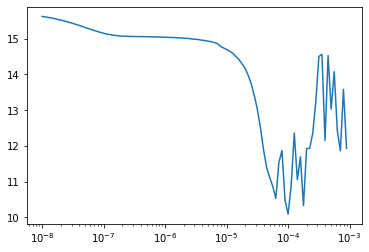

In [74]:
import matplotlib.pyplot as plt
plt.semilogx(history.history['lr'], history.history['loss'])

Train the model using the best learning rate for 500 epochs

In [77]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ]
)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
              , loss=tf.keras.losses.Huber(), metrics=["mse", "mae"])
history = model.fit(x=X_train, y=y_train, epochs=500)

Epoch 1/500
325/325 [==============================] - 1s 2ms/step - loss: 14.9519 - mse: 406.8265 - mae: 15.4443
Epoch 2/500
325/325 [==============================] - 1s 2ms/step - loss: 14.5568 - mse: 386.0925 - mae: 15.0492
Epoch 3/500
325/325 [==============================] - 1s 2ms/step - loss: 14.0264 - mse: 357.8959 - mae: 14.5192
Epoch 4/500
325/325 [==============================] - 1s 2ms/step - loss: 12.9212 - mse: 303.3429 - mae: 13.4133
Epoch 5/500
325/325 [==============================] - 1s 2ms/step - loss: 11.7394 - mse: 245.1104 - mae: 12.2307
Epoch 6/500
325/325 [==============================] - 1s 2ms/step - loss: 10.3936 - mse: 190.6854 - mae: 10.8839
Epoch 7/500
325/325 [==============================] - 1s 2ms/step - loss: 9.9930 - mse: 175.0056 - mae: 10.4833
Epoch 8/500
325/325 [==============================] - 1s 2ms/step - loss: 10.0397 - mse: 176.8209 - mae: 10.5297
Epoch 9/500
325/325 [==============================] - 1s 2ms/step - loss: 10.2612 - mse:

<Figure size 432x288 with 0 Axes>

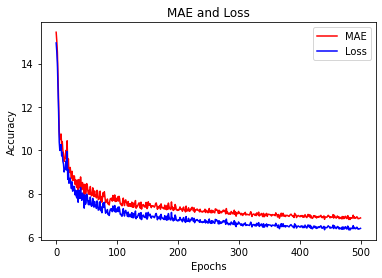

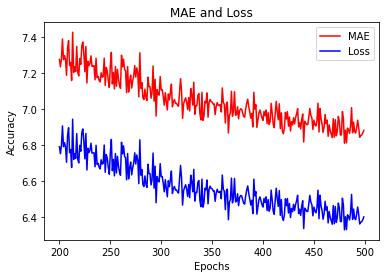

<Figure size 432x288 with 0 Axes>

In [78]:
mse = history.history['mse']
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [79]:
predictions = model.predict(X_test)

In [100]:
tf.keras.metrics.mean_absolute_error(y_test.values, predictions.reshape(-1)).numpy()

7.037126

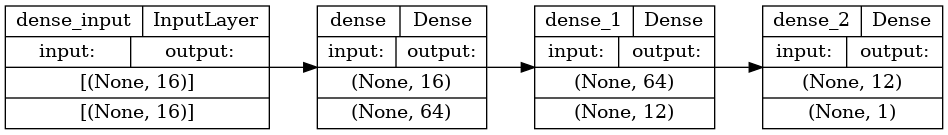

In [101]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")